In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input,Bidirectional,LSTM,Dense,Dropout,Concatenate
import tensorflow_probability as tfp
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

x_path = "data/"
y_path = "RECOLA/ratings_individual/ratings_individual/arousal/"
label_delay = 4
frame_length = 10
frame_step = 2
dropout_rate = 0.1

from numpy.random import seed
import matplotlib.pyplot as plt
seed(1)

In [2]:
#split data into frames for training
def framer(x,y, frame_length, frame_step):
    num_steps,num_features = x.shape
    num_annotators = y.shape[-1]
    x_out = []
    y_out = []
    step = 0
    while (step+frame_length <= num_steps):
        frame_x = x[step:step+frame_length,:]
        frame_y = y[step:step+frame_length,:]
        x_out.append(frame_x)
        y_out.append(frame_y)
        step = step+frame_step
    
    x_out = np.array(x_out)
    y_out = np.array(y_out)
    
    return x_out, y_out

#read data from csv files and align
def read_data(file_name, x_path, y_path):
    #read input data
    x_file = x_path + file_name
    df = pd.read_csv(x_file,sep=";")
    x = df.drop(['name','frameTime'],axis=1).to_numpy()

    #read output data
    y_file = y_path + file_name
    df = pd.read_csv(y_file,sep=";")
    y = df.drop("time",axis=1).to_numpy()

    #shift labels and match lengths
    trunc_front = np.int_(label_delay/0.04)
    trunc_back = trunc_front + x.shape[0]
    y = y[trunc_front:trunc_back,:]

    return x,y

def scale_train_inputs(x):
    #scale input features to range 0-1
    #https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/
    x_flat = x.reshape(-1, x.shape[-1])
    xmin = np.amin(x_flat, axis=0)
    xmax = np.amax(x_flat, axis=0)
    scaled = (x-xmin)/(xmax-xmin)
    return scaled, xmin, xmax

def scale_test_inputs(x, xmin, xmax):
    scaled = (x-xmin)/(xmax-xmin)
    return scaled

def scale_train_labels(y):
    y_flat = y.reshape(-1, y.shape[-1])
    ymean = np.mean(y_flat, axis=0)
    ystd = np.std(y_flat, axis=0)
    scaled = (y-ymean)/(4*ystd)
#     print(y.shape)
    return scaled, ymean, ystd

def scale_test_labels(y, ymean, ystd):
    scaled = (y-ymean)/(4*ystd)
    return scaled

def ccc(x, y):
#     ccc = 0
    x = tf.reshape(x, tf.shape(x)[0:-1])
    y = tf.reshape(y, tf.shape(y)[0:-1])
#     print(x.shape)
    x_mean = tf.math.reduce_mean(x,axis=-1)
    y_mean = tf.math.reduce_mean(y,axis=-1)
#     print(x_mean.shape)
    x_var = tf.math.reduce_variance(x,axis=-1)
    y_var = tf.math.reduce_variance(y,axis=-1)
#     print(x_var.shape)
    
    cov = tfp.stats.covariance(x, y, sample_axis=-1, event_axis=0)
#     print(cov.shape)
    cov = tf.linalg.diag_part(cov)
#     print(cov.shape)
    ccc = (2*cov)/(x_var+y_var+tf.square((x_mean-y_mean)))
    ccc = tf.math.reduce_mean(ccc)
#     print(ccc)
    return ccc

def my_ccc(x, y):
    x = x.flatten()
    y = y.flatten()
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    x_var = np.var(x)
    y_var = np.var(y)
    
    cov = np.cov(x,y)[0,1]
    ccc = (2*cov)/(x_var+y_var+(x_mean-y_mean)**2)
    
#     print(cov, x_mean, y_mean, x_var, y_var)
    return ccc

#normalize features to normal distribution
def normalize_train_inputs(x):
    
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    
    features = (x-mean)/std
    
    return features, mean, std

#rescale labels to normal distribution/3
def normalize_labels(y):
    
    mean = np.mean(y, axis=0)
    std = np.std(y, axis=0)
    
    y = (y-mean)/(3*std)
    y = np.clip(y,a_min=-1,a_max=1)
    
    return y

def my_nll(y_true, y_pred, y_pred_std):
    
    mean = y_pred
    variance = np.square(y_pred_std)
    nll = []
    for i in range(6):
        nll.append((np.log(variance) / 2 + ((y_true[:,frame_length-1,i] - mean) ** 2) / (2 * variance)))
        
    nll = np.mean(np.array(nll))
    return nll

In [3]:
#extract data
x_train = []
y_train = []
x_test = []
y_test = []

#training data
for i in range(1,10):
    file_name = "train_" + str(i) + ".csv"
    print(file_name)
    x,y = read_data(file_name,x_path,y_path)
#     y = normalize_labels(y)
    x,y = framer(x,y,frame_length,frame_step)
    x_train.append(x)
    y_train.append(y)

x_train = np.vstack(x_train)
y_train = np.vstack(y_train)
#scale input features to range 0-1
x_train, xmin, xmax = scale_train_inputs(x_train)
# y_train, ymean, ystd = scale_train_labels(y_train)
# y_train, ymin, ymax = scale_train_inputs(y_train)

#test(devel) data
for i in range(1,10):
    file_name = "dev_" + str(i) + ".csv"
    print(file_name)
    x,y = read_data(file_name,x_path,y_path)
#     y = normalize_labels(y)
    x,y = framer(x,y,frame_length,frame_step)
    x_test.append(x)
    y_test.append(y)

x_test = np.vstack(x_test)
y_test = np.vstack(y_test)
#scale input features to range 0-1 from learned scaling
x_test = scale_test_inputs(x_test, xmin, xmax)
# y_test = scale_test_labels(y_test, ymean, ystd)
# y_test = scale_test_inputs(y_test, ymin, ymax)

#obtain individual ratings for ambiguity modelling
y_train_multi = [y_train[:,:,i].reshape(*y_train.shape[0:-1],1) for i in range(6)]
y_test_multi = [y_test[:,:,i].reshape(*y_train.shape[0:-1],1) for i in range(6)]
y_train_multi = np.concatenate(y_train_multi, axis=2)
y_test_multi = np.concatenate(y_test_multi, axis=2)

#obtain stdev for ambiguity modelling
y_train_var = np.var(y_train,axis=-1).reshape(*y_train.shape[0:-1],1)
y_test_var = np.var(y_test,axis=-1).reshape(*y_test.shape[0:-1],1)

#obtain mean for gold standard training (average of all raters)
y_train = np.mean(y_train,axis=-1).reshape(*y_train.shape[0:-1],1)
y_test = np.mean(y_test,axis=-1).reshape(*y_test.shape[0:-1],1)

#concat mean and stdev for normal distribution approximation
# y_train_normal = np.concatenate([y_train, y_train_std], axis=2)
# y_test_normal = np.concatenate([y_test, y_test_std], axis=2)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_test_multi.shape)
# print(y_test_multi.shape)

# import matplotlib.pyplot as plt
print(y_train_var.shape)

train_1.csv
train_2.csv
train_3.csv
train_4.csv
train_5.csv
train_6.csv
train_7.csv
train_8.csv
train_9.csv
dev_1.csv
dev_2.csv
dev_3.csv
dev_4.csv
dev_5.csv
dev_6.csv
dev_7.csv
dev_8.csv
dev_9.csv
(33264, 10, 88)
(33264, 10, 1)
(33264, 10, 88)
(33264, 10, 1)
(33264, 10, 6)
(33264, 10, 1)


In [4]:
#build nll mean+std model
def my_nll_loss(y_true, y_pred):
    
    mean = y_pred[:,:,0]
    variance = y_pred[:,:,1]
    
    y = tf.math.reduce_mean(y_true,axis=2)
    
    nll = 0.5*(tf.math.log(variance) + ((y - mean) ** 2)/variance + 1.837877)
        #regularize
#         nll += rcoeff1*(y - mean)**2
#         nll += rcoeff2*variance

    return nll

def my_nll_gamma_loss(y_true, y_pred):
    
    alpha = y_pred[:,:,0]
    beta = y_pred[:,:,1]
    tol = 1/tf.math.reduce_variance(y_true,axis=2)

    nll = beta*tol + tf.math.lgamma(alpha) - (alpha-1)*tf.math.log(tol) - alpha*tf.math.log(beta)

    return nll


In [15]:
#ensemble of DNNs
num_models = 5
# models = []
var_models = []
# for i in range(num_models):
    
#     inputs = Input(shape=(frame_length,88))
#     x = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=dropout_rate))(inputs)
#     x = Dropout(dropout_rate)(x)
#     x = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=dropout_rate))(x)
#     x = Dropout(dropout_rate)(x)

#     mean = Dense(1, activation="tanh")(x)
#     var = Dense(1, activation="softplus")(x)
#     outputs = Concatenate()([mean, var])

#     model_nll = keras.Model(inputs, outputs)
#     model_nll.summary()
    
#     #train model
#     optimizer = keras.optimizers.Adam(learning_rate=0.0001)
#     model_nll.compile(optimizer=optimizer, loss=my_nll_loss)
#     early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min', min_delta=0.0001, restore_best_weights=True)
#     model_nll.fit(x_train,y_train_multi, batch_size=100, epochs=100, validation_split=0.1, shuffle=True, callbacks=[early_stopping])

#     models.append(model_nll)
    
for i in range(num_models):
    
    inputs = Input(shape=(frame_length,88))
    x = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=dropout_rate))(inputs)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=dropout_rate))(x)
    x = Dropout(dropout_rate)(x)

    mean = Dense(1, activation="softplus")(x)
    var = Dense(1, activation="softplus")(x)
    outputs = Concatenate()([mean, var])

    model_nll = keras.Model(inputs, outputs)
    model_nll.summary()
    
    #train model
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model_nll.compile(optimizer=optimizer, loss=my_nll_loss)
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min', min_delta=0.0001, restore_best_weights=True)
    model_nll.fit(x_train,y_train_var, batch_size=100, epochs=100, validation_split=0.1, shuffle=True, callbacks=[early_stopping])

    var_models.append(model_nll)

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 10, 88)]     0                                            
__________________________________________________________________________________________________
bidirectional_24 (Bidirectional (None, 10, 128)      78336       input_13[0][0]                   
__________________________________________________________________________________________________
dropout_24 (Dropout)            (None, 10, 128)      0           bidirectional_24[0][0]           
__________________________________________________________________________________________________
bidirectional_25 (Bidirectional (None, 10, 128)      98816       dropout_24[0][0]                 
___________________________________________________________________________________________

300/300 [==============================] - 13s 42ms/step - loss: -2.3749 - val_loss: -2.7548
Epoch 16/100
300/300 [==============================] - 13s 42ms/step - loss: -2.3918 - val_loss: -2.6211
Epoch 17/100
300/300 [==============================] - 13s 42ms/step - loss: -2.4067 - val_loss: -2.6322
Epoch 18/100
300/300 [==============================] - 13s 43ms/step - loss: -2.4160 - val_loss: -2.6570
Epoch 19/100
300/300 [==============================] - 13s 42ms/step - loss: -2.4334 - val_loss: -2.6085
Epoch 20/100
300/300 [==============================] - 12s 41ms/step - loss: -2.4458 - val_loss: -2.5533
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 10, 88)]     0                                            
______________________________________________________________

In [83]:
results = []
results_var = []
for i in range(num_models):
    print(i)
    results.append(models[i].predict(x_test))
    results_var.append(var_models[i].predict(x_test))

0
1
2
3
4


0.7563451922190056
0.3750460486025593
-0.802721623040906
0.12670556095086954


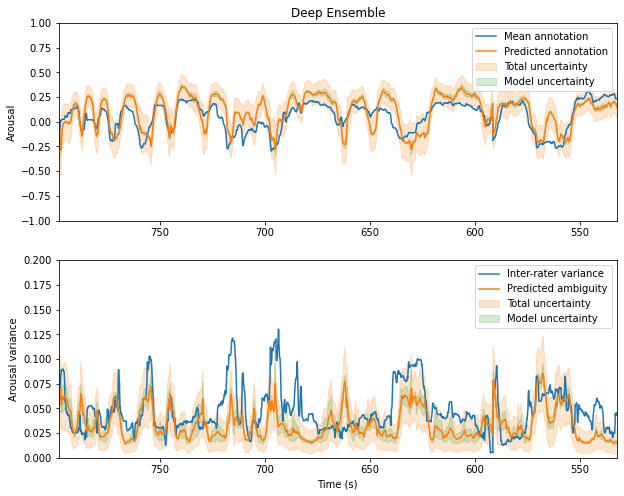

In [109]:
npresults = np.array(results)
npresults_var = np.array(results_var)
time_step = 0.04*frame_step
num_steps = npresults.shape[1]
time_start = file_num*time_step*num_steps/10
time_end = (file_num-1)*time_step*num_steps/10
time_stamps = np.arange(num_steps)*time_step

test = y_test[:,frame_length-1,0].flatten()
test_pred = np.mean(npresults[:,:,frame_length-1,0],axis=0).flatten()
test_var = y_test_var[:,frame_length-1,0].flatten()
test_pred_var = np.mean(npresults_var[:,:,frame_length-1,0],axis=0).flatten()

mv_pred = np.zeros([num_models,npresults.shape[1],1,2])
dunc = np.zeros([npresults.shape[1],2,2])
for m in range(num_models):

    mv_pred[m,:,0,0] = npresults[m,:,frame_length-1,0]
    mv_pred[m,:,0,1] = npresults_var[m,:,frame_length-1,0]
    dunc[:,0,0] += npresults[m,:,frame_length-1,1]/num_models
    dunc[:,1,1] += npresults_var[m,:,frame_length-1,1]/num_models

munc = np.zeros([npresults.shape[1],2,2])
mv_pred_ave = np.mean(mv_pred,axis=0)
for m in range(num_models):
    diff_m = mv_pred[m,:,:] - mv_pred_ave
    munc += np.matmul( diff_m.transpose(0,2,1),diff_m)
    
munc = munc/(num_models-1)

test_pred_std = np.sqrt(mv_pred_ave[:,0,1])
munc_la = np.sqrt(munc[:,0,0])
dunc_la = np.sqrt(dunc[:,0,0])
tunc_la = np.sqrt(munc[:,0,0]+dunc[:,0,0])
munc_amb = np.sqrt(munc[:,1,1])
dunc_amb = np.sqrt(dunc[:,1,1])
tunc_amb = np.sqrt(munc[:,1,1]+dunc[:,1,1])
dunc_1 = np.sqrt(np.linalg.det(dunc))
munc_1 = np.sqrt(np.linalg.det(munc))

fig, axs = plt.subplots(2)
fig.set_size_inches(10,8)

axs[0].set_title('Deep Ensemble')
axs[0].set_xlim([time_start,time_end])
axs[0].set_ylim([-1,1])
axs[0].set_ylabel('Arousal')
axs[0].plot(time_stamps, test, label='Mean annotation')
axs[0].plot(time_stamps, test_pred, label='Predicted annotation')
# for i in range(num_models):
#     axs[0].plot(np.abs(mv_pred[i,:,0,0]-mv_pred_ave[:,0,0])+0.5)
#     axs[0].plot(np.abs(mv_pred[i,:,0,1]-mv_pred_ave[:,0,1])-0.5)
# axs[0].plot(test_pred_unc)
# axs[0].plot(np.sqrt(munc[:,0,0])-1, label='predicted model uncertainty - 1')
# axs[0].plot(np.sqrt(dunc[:,0,0])-1, label='predicted data uncertainty - 1')
axs[0].fill_between(time_stamps, test_pred-tunc_la,test_pred+tunc_la,color='C1',alpha=0.2, label='Total uncertainty')
axs[0].fill_between(time_stamps, test_pred-munc_la,test_pred+munc_la,color='C2',alpha=0.2, label='Model uncertainty')
axs[0].legend(loc='upper right')


axs[1].set_xlim([time_start,time_end])
axs[1].set_ylim([0,0.2])
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Arousal variance')
axs[1].plot(time_stamps, test_var, label='Inter-rater variance')
axs[1].plot(time_stamps, test_pred_var, label='Predicted ambiguity')
# axs[1].plot(np.sqrt(munc[:,1,1]), label='predicted model uncertainty')
# axs[1].plot(np.sqrt(dunc[:,1,1]), label='predicted data uncertainty')
axs[1].fill_between(time_stamps, test_pred_var-tunc_amb,test_pred_var+tunc_amb,color='C1',alpha=0.2, label='Total uncertainty')
axs[1].fill_between(time_stamps, test_pred_var-munc_amb,test_pred_var+munc_amb,color='C2',alpha=0.2, label='Model uncertainty')
axs[1].legend(loc='upper right')

print(my_ccc(test,test_pred))
print(my_ccc(test_var,test_pred_var))
print(my_nll(y_test_multi, test_pred, np.sqrt(test_pred_var+dunc[:,0,0]+munc[:,0,0])))
print(np.sqrt(np.mean((test-test_pred)**2)))
# print(np.mean(munc[:,0,0]))
# print(np.mean(dunc[:,0,0]))
# print(np.mean(munc[:,1,1]))
# print(np.mean(dunc[:,1,1]))

In [32]:
len(time_stamps)

33264

In [200]:
#build nll mean+std model
def my_dual_nll_loss(y_true, y_pred):
    
    mu = y_pred[:,:,0]
    sigma2 = y_pred[:,:,1]
    alpha = y_pred[:,:,2]
    beta = y_pred[:,:,3]
    
    num_labels = y_true.shape[2]
    y = tf.math.reduce_mean(y_true,axis=2) #annotation mean
    tol = 1/tf.math.reduce_variance(y_true,axis=2) #tolerance = 1/variance
    Vamb = (beta/(alpha-1))/num_labels
    
    nll = 0.5*(tf.math.log(sigma2+Vamb) + ((y - mu) ** 2)/(sigma2+Vamb) + 1.837877) #fit mean
    nll += beta*tol + tf.math.lgamma(alpha) - (alpha-1)*tf.math.log(tol) - alpha*tf.math.log(beta) #fit amb
    
    return nll


In [201]:
#ensemble of DNNs
num_models = 5
dual_models = []
rcoeff = 0#.001
for i in range(num_models):
    
    inputs = Input(shape=(frame_length,88))
    x = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=dropout_rate, kernel_regularizer=regularizers.l2(rcoeff)))(inputs)
#     x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=dropout_rate, kernel_regularizer=regularizers.l2(rcoeff)))(x)
#     x = Dropout(dropout_rate)(x)
    mean = Dense(1, activation="tanh")(x)
    variance = Dense(1, activation="softplus")(x)
    alpha = Dense(1, activation="softplus")(x)
    beta = Dense(1, activation="softplus")(x)
    outputs = Concatenate()([mean, variance, alpha+1, beta]) #4 parameters of NIG distribution

    model_dual = keras.Model(inputs, outputs)
    model_dual.summary()
    
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model_dual.compile(optimizer=optimizer, loss=my_dual_nll_loss)
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto', min_delta=0.0001, restore_best_weights=True)
    model_dual.fit(x_train,y_train_multi, batch_size=100, epochs=100, validation_split=0.1, shuffle=True, callbacks=[early_stopping])

    
    dual_models.append(model_dual)

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 10, 88)]     0                                            
__________________________________________________________________________________________________
bidirectional_42 (Bidirectional (None, 10, 128)      78336       input_23[0][0]                   
__________________________________________________________________________________________________
bidirectional_43 (Bidirectional (None, 10, 128)      98816       bidirectional_42[0][0]           
__________________________________________________________________________________________________
dense_84 (Dense)                (None, 10, 1)        129         bidirectional_43[0][0]           
___________________________________________________________________________________________

300/300 [==============================] - 22s 58ms/step - loss: 6.8646 - val_loss: 4.1364
Epoch 2/100
300/300 [==============================] - 17s 55ms/step - loss: 4.2620 - val_loss: 3.8986
Epoch 3/100
300/300 [==============================] - 17s 55ms/step - loss: 4.0825 - val_loss: 3.9619
Epoch 4/100
300/300 [==============================] - 17s 55ms/step - loss: 4.0137 - val_loss: 3.8717
Epoch 5/100
300/300 [==============================] - 17s 55ms/step - loss: 3.9609 - val_loss: 3.9952
Epoch 6/100
300/300 [==============================] - 17s 55ms/step - loss: 3.9210 - val_loss: 4.1259
Epoch 7/100
300/300 [==============================] - 17s 55ms/step - loss: 3.8887 - val_loss: 3.9338
Epoch 8/100
300/300 [==============================] - 17s 56ms/step - loss: 3.8422 - val_loss: 4.0077
Epoch 9/100
300/300 [==============================] - 17s 56ms/step - loss: 3.8167 - val_loss: 4.0559
Model: "model_24"
___________________________________________________________________

Epoch 7/100
300/300 [==============================] - 27s 90ms/step - loss: 3.8740 - val_loss: 3.9714
Epoch 8/100
300/300 [==============================] - 28s 92ms/step - loss: 3.8294 - val_loss: 4.0901
Epoch 9/100
300/300 [==============================] - 28s 92ms/step - loss: 3.7958 - val_loss: 4.2673


In [202]:
results = []
for i in range(num_models):
    print(i)
    results.append(dual_models[i].predict(x_test))

0
1
2
3
4


0.7470383889616536
0.42029996411690485
0.4691957707288798
-0.8131476194582088


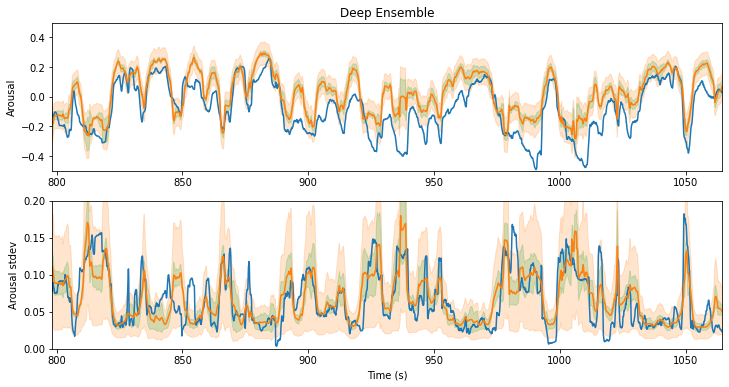

In [203]:
npresults = np.array(results)
time_step = 0.04*frame_step
num_steps = npresults.shape[1]
file_num = 3
time_start = file_num*time_step*num_steps/10
time_end = (file_num+1)*time_step*num_steps/10
time_stamps = np.arange(num_steps)*time_step

test = y_test[:,frame_length-1,0].flatten()
test_pred = np.mean(npresults[:,:,frame_length-1,0],axis=0).flatten()
test_var = y_test_var[:,frame_length-1,0].flatten()
test_pred_var = np.zeros((test.shape[0],))

mv_pred = np.zeros([num_models,npresults.shape[1],1,2])
dunc = np.zeros([npresults.shape[1],2,2])
dunc_lo = np.zeros([npresults.shape[1],])
for m in range(num_models):
    
#     nu = npresults[m,:,frame_length-1,1].flatten()
    alpha = npresults[m,:,frame_length-1,2].flatten()
    beta = npresults[m,:,frame_length-1,3].flatten()
    
    pred_amb_m = beta/(alpha-1)

    mv_pred[m,:,0,0] = npresults[m,:,frame_length-1,0]
    mv_pred[m,:,0,1] = pred_amb_m
    
    dunc[:,0,0] += npresults[m,:,frame_length-1,1]/num_models
    dunc[:,1,1] += (beta**2/alpha)/num_models
    
    dunc_lo += (beta/(alpha))/num_models

munc = np.zeros([npresults.shape[1],2,2])
mv_pred_ave = np.mean(mv_pred,axis=0)
for m in range(num_models):
    diff_m = mv_pred[m,:,:] - mv_pred_ave
    munc += np.matmul( diff_m.transpose(0,2,1),diff_m)
    
munc = munc/(num_models-1)

test_pred_var = mv_pred_ave[:,0,1]
munc_la = np.sqrt(munc[:,0,0])
dunc_la = np.sqrt(dunc[:,0,0])
tunc_la = np.sqrt(munc[:,0,0]+dunc[:,0,0])
munc_amb = np.sqrt(munc[:,1,1])
dunc_amb = np.sqrt(dunc[:,1,1])
tunc_amb = np.sqrt(munc[:,1,1]+dunc[:,1,1])
dunc_1 = np.sqrt(np.linalg.det(dunc))
munc_1 = np.sqrt(np.linalg.det(munc))

fig, axs = plt.subplots(2)
fig.set_size_inches(12,6)

axs[0].set_title('Deep Ensemble')
axs[0].set_xlim([time_start,time_end])
axs[0].set_ylim([-0.5,0.5])
axs[0].set_ylabel('Arousal')
axs[0].plot(time_stamps, test, label='Mean annotation')
axs[0].plot(time_stamps, test_pred, label='Predicted annotation')
axs[0].fill_between(time_stamps, test_pred-tunc_la,test_pred+tunc_la,color='C1',alpha=0.2, label='Total uncertainty')
axs[0].fill_between(time_stamps, test_pred-munc_la,test_pred+munc_la,color='C2',alpha=0.2, label='Model uncertainty')
# axs[0].legend(loc='upper right')


axs[1].set_xlim([time_start,time_end])
axs[1].set_ylim([0,0.2])
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Arousal stdev')
axs[1].plot(time_stamps, test_var, label='Inter-rater variance')
axs[1].plot(time_stamps, test_pred_var, label='Predicted ambiguity')
axs[1].fill_between(time_stamps, test_pred_var-tunc_amb,test_pred_var+tunc_amb,color='C1',alpha=0.2, label='Total uncertainty')
axs[1].fill_between(time_stamps, test_pred_var-munc_amb,test_pred_var+munc_amb,color='C2',alpha=0.2, label='Model uncertainty')
# axs[1].legend(loc='upper right')

print(my_ccc(test,test_pred))
print(my_ccc(test_var,test_pred_var))
print(my_ccc(np.sqrt(test_var),np.sqrt(test_pred_var)))
print(my_nll(y_test_multi, test_pred, np.sqrt(test_pred_var+dunc[:,0,0]+munc[:,0,0])))

532.2239999999999

In [164]:
inputs = Input(shape=(frame_length,88))
x = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=dropout_rate))(inputs)
x = Dropout(dropout_rate)(x)
x = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=dropout_rate))(x)
x = Dropout(dropout_rate)(x)

mean = Dense(1, activation="tanh")(x)
var = Dense(1, activation="softplus")(x)
outputs = [mean, var]
# outputs = Concatenate()([mean, var])

model_mse = keras.Model(inputs, outputs)
model_mse.summary()

#train model
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_mse.compile(optimizer=optimizer, loss='mse')
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min', min_delta=0.0001, restore_best_weights=True)
model_mse.fit(x_train,[y_train,y_train_var], batch_size=100, epochs=100, validation_split=0.1, shuffle=True, callbacks=[early_stopping])


Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 10, 88)]     0                                            
__________________________________________________________________________________________________
bidirectional_30 (Bidirectional (None, 10, 128)      78336       input_17[0][0]                   
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 10, 128)      0           bidirectional_30[0][0]           
__________________________________________________________________________________________________
bidirectional_31 (Bidirectional (None, 10, 128)      98816       dropout_10[0][0]                 
___________________________________________________________________________________________

In [165]:
pred_basic = model_mse.predict(x_test)

In [166]:
test = y_test[:,frame_length-1,0].flatten()
test_var = y_test_var[:,frame_length-1,0].flatten()

test_pred = pred_basic[0][:,frame_length-1,0].flatten()
test_pred_var = pred_basic[1][:,frame_length-1,0].flatten()

print(my_ccc(test,test_pred))
print(my_ccc(test_var,test_pred_var))
print(my_ccc(np.sqrt(test_var),np.sqrt(test_pred_var)))
print(my_nll(y_test_multi, test_pred, np.sqrt(test_pred_var)))
print(np.sqrt(np.mean((test-test_pred)**2)))
print(np.sqrt(np.mean((test_var-test_pred_var)**2)))
print(np.sqrt(np.mean((np.sqrt(test_var)-np.sqrt(test_pred_var))**2)))
# plt.plot(test_pred)
# plt.plot(test_var)
# plt.plot(test_pred_var)

0.7493608520942612
0.3996788645161025
0.40691779987715215
-0.8041008617722913
0.12969758600825038
0.03303273401295255
0.06523014820571764


C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_9716/2622412786.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  conf.append(np.sqrt(np.mean(np.square(tunc_la[index]))))
C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_9716/2622412786.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rmse.append(np.sqrt(np.mean(np.square(test[index]-test_pred[index]))))
C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_9716/2622412786.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead 

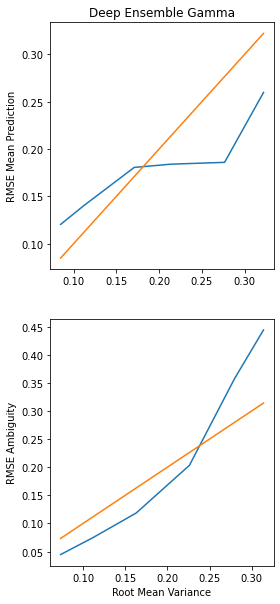

In [204]:
# np.argsort(np.square(test-test_pred))
a = np.flip(np.argsort(tunc_la))
b = tunc_la[a]
c = b[n_bin]

conf = []
rmse = []
for thresh in [0.1,0.15,0.2,0.25,0.3,0.35]:
    index = [(tunc_la<thresh) * (tunc_la>(thresh-0.05))]
    conf.append(np.sqrt(np.mean(np.square(tunc_la[index]))))
    rmse.append(np.sqrt(np.mean(np.square(test[index]-test_pred[index]))))

fig, axs = plt.subplots(2)
fig.set_size_inches(4,10)

axs[0].set_title('Deep Ensemble Gamma')
axs[0].set_ylabel('RMSE Mean Prediction')
axs[0].plot(conf,rmse)
axs[0].plot(conf,conf)

conf = []
rmse = []
for thresh in [0.1,0.15,0.2,0.25,0.3,0.35]:
    index = [(tunc_amb<thresh) * (tunc_amb>(thresh-0.05))]
    conf.append(np.sqrt(np.mean(np.square(tunc_amb[index]))))
    rmse.append(np.sqrt(np.mean(np.square(test_pred_var[index]-test_var[index]))))

axs[1].set_xlabel('Root Mean Variance')
axs[1].set_ylabel('RMSE Ambiguity')
axs[1].plot(conf,rmse)
axs[1].plot(conf,conf)


C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_9716/3459825046.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  conf.append(np.sqrt(np.mean(np.square(tunc_amb[index]))))
C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_9716/3459825046.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rmse.append(np.sqrt(np.mean(np.square(test_pred_var[index]-test_var[index]))))


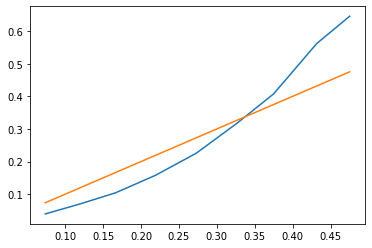

In [101]:
conf = []
rmse = []
for thresh in [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]:
    index = [(tunc_amb<thresh) * (tunc_amb>(thresh-0.05))]
    conf.append(np.sqrt(np.mean(np.square(tunc_amb[index]))))
    rmse.append(np.sqrt(np.mean(np.square(test_pred_var[index]-test_var[index]))))

plt.plot(conf,rmse)
plt.plot(conf,conf)

C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_9716/3347970670.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  conf.append(np.sqrt(np.mean(test_pred_var[index])))
C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_9716/3347970670.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rmse.append(np.sqrt(np.mean(test_var[index])))
C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_9716/3347970670.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future th

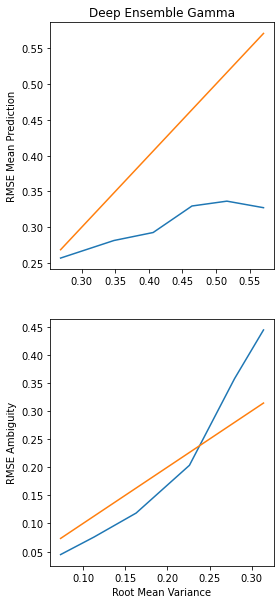

In [209]:
conf = []
rmse = []
for thresh in [0.1,0.15,0.2,0.25,0.3,0.35]:
    index = [(test_pred_var<thresh) * (test_pred_var>(thresh-0.05))]
    conf.append(np.sqrt(np.mean(test_pred_var[index])))
    rmse.append(np.sqrt(np.mean(test_var[index])))

fig, axs = plt.subplots(2)
fig.set_size_inches(4,10)

axs[0].set_title('Deep Ensemble Gamma')
axs[0].set_ylabel('RMSE Mean Prediction')
axs[0].plot(conf,rmse)
axs[0].plot(conf,conf)

conf = []
rmse = []
for thresh in [0.1,0.15,0.2,0.25,0.3,0.35]:
    index = [(tunc_amb<thresh) * (tunc_amb>(thresh-0.05))]
    conf.append(np.sqrt(np.mean(np.square(tunc_amb[index]))))
    rmse.append(np.sqrt(np.mean(np.square(test_pred_var[index]-test_var[index]))))

axs[1].set_xlabel('Root Mean Variance')
axs[1].set_ylabel('RMSE Ambiguity')
axs[1].plot(conf,rmse)
axs[1].plot(conf,conf)

0.2815939096966654

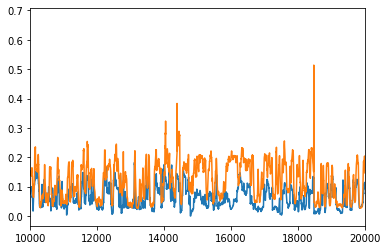

In [210]:
plt.plot(test_var)
plt.plot(np.sqrt(tunc_amb)-0.1)
plt.xlim([10000,20000])
my_ccc(np.sqrt(tunc_amb)-0.1, test_var)